In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
df = pd.read_csv('normalized_dataset.csv')
df_encoded = pd.get_dummies(df, columns=['Section'], drop_first=True)
df_encoded['FailureMode'] = df_encoded['FailureMode'] - 1  # 将 [1,2,3,4] 转换为 [0,1,2,3]


X = df_encoded.drop(['Unnamed: 0', 'FailureMode'], axis=1)
y = df_encoded['FailureMode']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test)

param_grid_xgb = {
    'n_estimators': [50, 100, 150],         
    'max_depth': [3, 4, 5],                 
    'learning_rate': [0.1, 0.05, 0.01],       
    'subsample': [0.8, 1]                    
}


xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=10, verbose=2, n_jobs=-1)
grid_xgb.fit(X_train_pca, y_train_smote)

print("Best parameter configuration:", grid_xgb.best_params_)
print("Best model:", grid_xgb.best_estimator_)

y_pred_xgb = grid_xgb.predict(X_test_pca)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb, average='macro')
recall = recall_score(y_test, y_pred_xgb, average='macro')
f1 = f1_score(y_test, y_pred_xgb, average='macro')

print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


C:\Users\15842\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:48:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameter configuration: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.8}
Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

Classification Report:
              precision    recall  f1-score   support

           0       0.90  

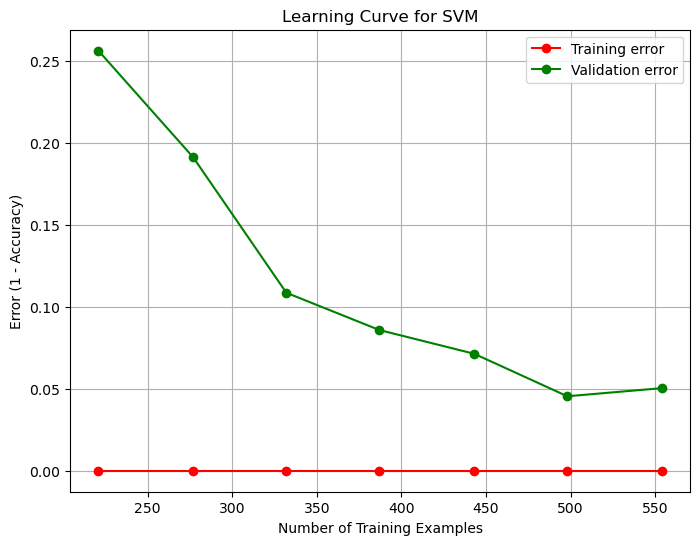

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Use the best estimator from GridSearchCV for generating the learning curve
best_estimator = grid_xgb.best_estimator_

# Compute learning curve scores
train_sizes, train_scores, test_scores = learning_curve(
    best_estimator,
    X_train_pca,
    y_train_smote,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Calculate training and validation errors
train_errors = 1 - np.mean(train_scores, axis=1)
validation_errors = 1 - np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_errors, 'o-', color="r", label="Training error")
plt.plot(train_sizes, validation_errors, 'o-', color="g", label="Validation error")
plt.xlabel("Number of Training Examples")
plt.ylabel("Error (1 - Accuracy)")
plt.title("Learning Curve for SVM")
plt.legend(loc="best")
plt.grid(True)
plt.show()